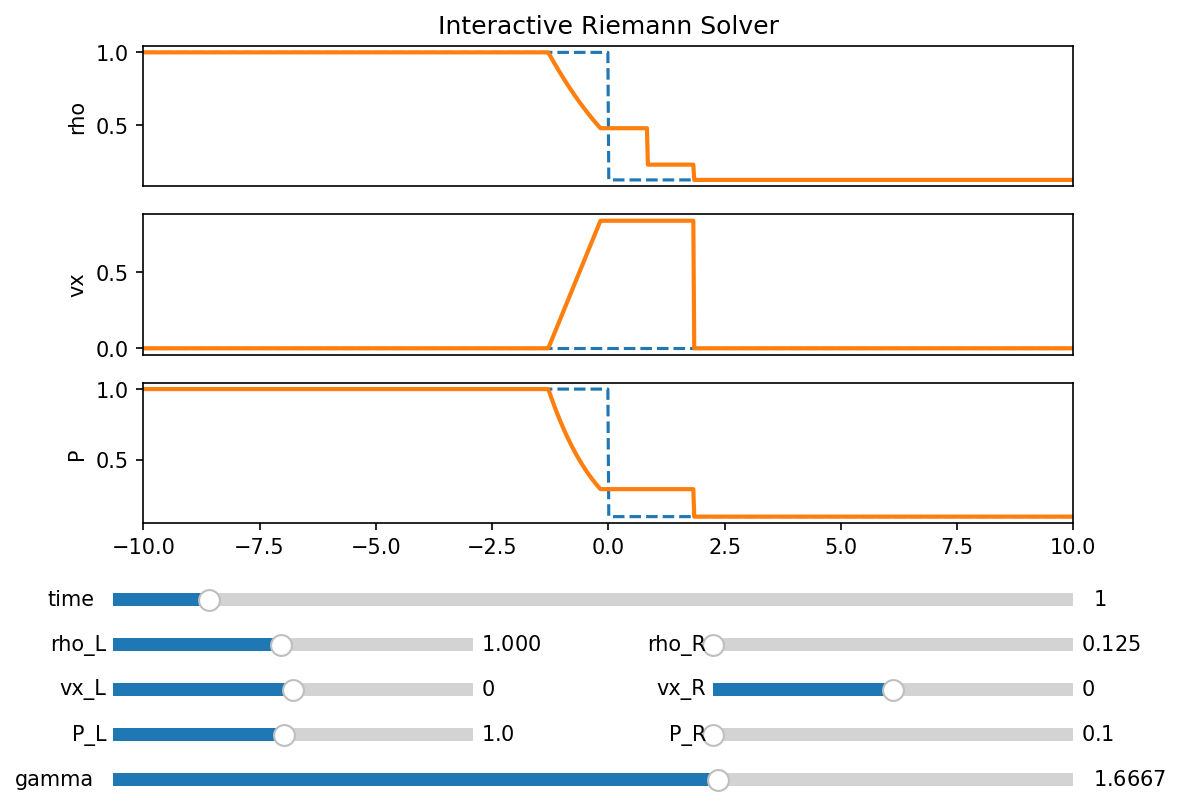

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider, Button


class RiemannSolver():
	
	def __init__(self, rho_L, vx_L, P_L, rho_R, vx_R, P_R, gamma, t):
		"""
		Initialize Riemann Solver
		"""
		
		self.set_state(rho_L, vx_L, P_L, rho_R, vx_R, P_R, gamma, t)
		
		Lbox     = 20.0   # domain [-Lbox/2,Lbox/2], shock initially at x=0
		N        = 1024   # resolution
		
		self.x   = np.linspace(-Lbox/2,Lbox/2,N)
		self.rho = np.zeros(N)
		self.vx  = np.zeros(N)
		self.P   = np.zeros(N)
		
		
	def set_state(self, rho_L, vx_L, P_L, rho_R, vx_R, P_R, gamma, t):
		"""
		Set Left and Right States
		"""
		self.rho_L = rho_L
		self.vx_L  = vx_L
		self.P_L   = P_L
		self.rho_R = rho_R
		self.vx_R  = vx_R
		self.P_R   = P_R
		self.gamma = gamma
		self.t     = t
		
		self.P_star  = 0      # pressure solution in star region
		self.vx_star = 0      # velocity solution in star region
		self.success = False  # solve succesful?
		
		# Gamma-related constants
		self.g1 = (gamma - 1.0) / (2.0*gamma)
		self.g2 = (gamma + 1.0) / (2.0*gamma)
		self.g3 = 2.0 * gamma / (gamma - 1.0)
		self.g4 = 2.0 / (gamma - 1.0)
		self.g5 = 2.0 / (gamma + 1.0)
		self.g6 = (gamma - 1.0) / (gamma + 1.0)
		self.g7 = (gamma - 1.0) / 2.0
		self.g8 = gamma - 1.0
		self.g9 = 1.0 / gamma
		
		# sound speeds
		self.c_L = np.sqrt(gamma*P_L/rho_L)
		self.c_R = np.sqrt(gamma*P_R/rho_R)
		
		
	def calc_star_P_and_vx(self):
		"""
		Compute solution for pressure & velocity in the star region
		"""

		tolerance = 1.0e-8
		max_iter  = 100


		P_old = self.guess_P()
		vx_diff = self.vx_R - self.vx_L

		# compute pressure in star region via Newton-Raphson iteration
		for i in np.arange(max_iter):
			
			(f_L, df_L) = self.pressure_function_and_derivative(P_old, self.rho_L, self.P_L, self.c_L)
			(f_R, df_R) = self.pressure_function_and_derivative(P_old, self.rho_R, self.P_R, self.c_R)
			
			P = P_old - (f_L + f_R + vx_diff) / (df_L + df_R)
			change = 2.0 * abs((P - P_old)/(P + P_old))
			
			if change < tolerance:
				break	
				
			if (P < 0.0): 
				P = tolerance
				
			P_old = P
			
		# compute velocity in Star Region
		vx = 0.5*(self.vx_L + self.vx_R + f_R - f_L)
		
		
		return (P, vx)
			


	def guess_P(self):
		"""
		Provide an initial guess for pressure in the Star Region.
		Based on approxiate riemann solvers, see section 9.5 in Toro
		"""
		q_threshold = 2.0

		# primitive variable riemann solver
		cup   = 0.25*(self.rho_L + self.rho_R)*(self.c_L + self.c_R)
		P_pv  = 0.5*(self.P_L + self.P_R) + 0.5*(self.vx_L - self.vx_R)*cup
		P_pv  = max(0.0, P_pv)
		P_min = min(self.P_L, self.P_R)
		P_max = max(self.P_L, self.P_R)
		q     = P_max/P_min

		if (q<q_threshold) and (P_min<P_pv) and (P_pv<P_max):
			# Select Primitive Variable Riemann solver
			P_guess = P_pv
		elif (P_pv < P_min):
			# Select Two-Rarefaction Riemann Solver
			Pq  = (self.P_L/self.P_R)**self.g1
			vxm = (Pq*self.vx_L/self.c_L + self.vx_R/self.c_R + self.g4*(Pq - 1.0)) /( Pq/self.c_L + 1.0/self.c_R)
			ptL = 1.0 + self.g7*(self.vx_L - vxm)/self.c_L
			ptR = 1.0 + self.g7*(vxm - self.vx_R)/self.c_R
			P_guess = 0.5*(self.P_L*ptL**self.g3 + self.P_R*ptR**self.g3)
		else:
			# Select Two-Shock Riemann Solver with PVRS as estimate
			geL = np.sqrt((self.g5/self.rho_L)/(self.g6*self.P_L + P_pv))
			geR = np.sqrt((self.g5/self.rho_R)/(self.g6*self.P_R + P_pv))
			P_guess = (geL*self.P_L + geR*self.P_R - (self.vx_R - self.vx_L))/(geL + geR)
		  
		return P_guess



	def pressure_function_and_derivative(self, P, rho_k, P_k, c_k):
		"""
		Evaluate functions to solve for pressure in Newton-Raphson iterator
		"""
		if P <= P_k:
			# Rarefaction Wave
			q = P/P_k
			f  = self.g4 * c_k* (q**self.g1 - 1.0)
			df = (1.0/(rho_k*c_k)) * q**(-self.g2)

		else:
			# Shock Wave
			ak = self.g5/rho_k
			bk = self.g6*P_k
			qrt = np.sqrt(ak/(bk + P))
			f  = (P - P_k) * qrt
			df = (1.0 - 0.5*(P - P_k)/(bk + P))*qrt

		return (f,df)



	def sample(self, P_star, vx_star, s):
		"""
		Sample the solution, given the Star region pressure and velocity, 
		in terms of s = x/t
		"""
		if (s <= vx_star):
			# Sampling point lies to the left of the contact discontinuity 
			if (P_star <= self.P_L):
				# Left Rarefaction 
				sh_L = self.vx_L - self.c_L

				if (s <= sh_L):
					# Sampled point is left data state 
					rho = self.rho_L
					vx  = self.vx_L
					P   = self.P_L

				else:
					cmL = self.c_L*(P_star/self.P_L)**self.g1
					st_L = vx_star - cmL

					if (s > st_L):
						# Sampled point is Star Left state
						rho = self.rho_L*(P_star/self.P_L)**self.g9
						vx  = vx_star
						P   = P_star

					else:
						# Sampled point is inside left fan
						vx  = self.g5*(self.c_L + self.g7*self.vx_L + s)
						c   = self.g5*(self.c_L + self.g7*(self.vx_L - s))
						rho = self.rho_L * (c/self.c_L)**self.g4
						P   = self.P_L * (c/self.c_L)**self.g3


			else:
				# Left shock 
				P_starL = P_star/self.P_L
				s_L = self.vx_L - self.c_L*np.sqrt(self.g2*P_starL + self.g1)

				if (s <= s_L):
					# Sampled point is left data state
					rho = self.rho_L
					vx  = self.vx_L
					P   = self.P_L

				else:
					# Sampled point is Star Left state
					rho = self.rho_L*(P_starL + self.g6)/(P_starL*self.g6 + 1.0)
					vx  = vx_star
					P   = P_star


		else:
			# Sampling point lies to the right of the contact discontinuity
			if (P_star > self.P_R):
				# Right Shock

				P_starR = P_star/self.P_R
				s_R = self.vx_R + self.c_R*np.sqrt(self.g2*P_starR + self.g1)

				if (s >= s_R):
					# Sampled point is right data state
					rho = self.rho_R
					vx  = self.vx_R
					P   = self.P_R

				else:
					# Sampled point is Star Right state
					rho = self.rho_R*(P_starR + self.g6)/(P_starR*self.g6 + 1.0)
					vx  = vx_star
					P   = P_star

			else:
				# Right Rarefaction
				sh_R = self.vx_R + self.c_R

				if (s >= sh_R):
					# Sampled point is right data state
					rho = self.rho_R
					vx  = self.vx_R
					P   = self.P_R

				else:
					cmR = self.c_R*(P_star/self.P_R)**self.g1
					st_R = vx_star + cmR

					if (s <= st_R):
						# Sampled point is Star Right state
						rho = self.rho_R*(P_star/self.P_R)**self.g9
						vx  = vx_star
						P   = P_star

					else:
						# Sampled point is inside left fan
						vx  = self.g5*(-self.c_R + self.g7*self.vx_R + s)
						c   = self.g5*(self.c_R - self.g7*(self.vx_R - s))
						rho = self.rho_R*(c/self.c_R)**self.g4
						P   = self.P_R*(c/self.c_R)**self.g3

		return (rho, vx, P)
		
		
		
	def solve(self):
		
		# Check pressure positivity condition
		if (self.g4*(self.c_L+self.c_R) < (self.vx_R - self.vx_L)):
			print("Error: initial data is such that the vacuum is generated!")
			self.success = False
			
		# Find exact solution for pressure & velocity in star region
		(P_star, vx_star) = self.calc_star_P_and_vx()	
		
		for i in np.arange(len(self.x)):
			s = self.x[i]/self.t
			(rho, vx, P) = self.sample(P_star, vx_star, s)
			self.rho[i] = rho
			self.vx[i]  = vx
			self.P[i]   = P
			
		self.success = True
		return (self.x, self.rho, self.vx, self.P)
		



def main():
	""" Interactive Riemann Solver """

	# Left State
	rho_L = 1.0
	vx_L  = 0.0
	P_L   = 1.0

	# Right State
	rho_R = 0.125
	vx_R  = 0.0
	P_R   = 0.1

	# ideal gas gamma
	gamma = 5./3. 
	
	# time 
	t     = 1.0
	
	# Riemann Solver 
	rs = RiemannSolver(rho_L, vx_L, P_L, rho_R, vx_R, P_R, gamma, t)
	x, rho, vx, P = rs.solve()

	# Create Interactive figure
	fig = plt.figure(figsize=(8,6), dpi=150)
	plt.subplots_adjust(bottom=0.35)
	
	ax1 = fig.add_subplot(311)
	plt.title('Interactive Riemann Solver')
	l1, = plt.plot(x, rho_L*(x<=0) + rho_R*(x>0), '--')
	l1b,= plt.plot(x, rho, linewidth=2)
	ax1.set_xticks([])
	ax1.set_xlim(-10,10)
	ax1.set_ylabel('rho')
	
	ax2 = fig.add_subplot(312)
	l2, = plt.plot(x, vx_L*(x<=0) + vx_R*(x>0), '--')
	l2b,= plt.plot(x, vx, linewidth=2)
	ax2.set_xticks([])
	ax2.set_xlim(-10,10)
	ax2.set_ylabel('vx')
	
	ax3 = fig.add_subplot(313)
	l3, = plt.plot(x, P_L*(x<=0) + P_R*(x>0), '--')
	l3b,= plt.plot(x, P, linewidth=2)
	ax3.set_xlim(-10,10)
	ax3.set_ylabel('P')
	
	# Create axes for sliders
	ax_t     = plt.axes([0.1, 0.25, 0.8, 0.03])
	ax_rho_L = plt.axes([0.1, 0.20, 0.3, 0.03])
	ax_vx_L  = plt.axes([0.1, 0.15, 0.3, 0.03])
	ax_P_L   = plt.axes([0.1, 0.10, 0.3, 0.03])
	ax_rho_R = plt.axes([0.6, 0.20, 0.3, 0.03])
	ax_vx_R  = plt.axes([0.6, 0.15, 0.3, 0.03])
	ax_P_R   = plt.axes([0.6, 0.10, 0.3, 0.03])
	ax_gamma = plt.axes([0.1, 0.05, 0.8, 0.03])
	
	# Create sliders
	sl_t     = Slider(ax_t, 'time', 0.0, 10.0, valinit=t)
	sl_rho_L = Slider(ax_rho_L, 'rho_L', 0.125, 2.0, valinit=rho_L)
	sl_vx_L  = Slider(ax_vx_L, 'vx_L', -2.0, 2.0, valinit=vx_L)
	sl_P_L   = Slider(ax_P_L, 'P_L', 0.1, 2.0, valinit=P_L)
	sl_rho_R = Slider(ax_rho_R, 'rho_R', 0.125, 2.0, valinit=rho_R)
	sl_vx_R  = Slider(ax_vx_R, 'vx_R', -2.0, 2.0, valinit=vx_R)
	sl_P_R   = Slider(ax_P_R, 'P_R', 0.1, 2.0, valinit=P_R)
	sl_gamma = Slider(ax_gamma, 'gamma', 1.1, 2.0, valinit=gamma)
	
	# update plot function
	def update(val):
		
		t     = sl_t.val
		rho_L = sl_rho_L.val
		vx_L  = sl_vx_L.val
		P_L   = sl_P_L.val
		rho_R = sl_rho_R.val
		vx_R  = sl_vx_R.val
		P_R   = sl_P_R.val
		gamma = sl_gamma.val
		
		rs.set_state(rho_L, vx_L, P_L, rho_R, vx_R, P_R, gamma, t)
		
		x, rho, vx, P = rs.solve()
		
		l1.set_ydata(rho_L*(x<=0) + rho_R*(x>0))
		l2.set_ydata(vx_L*(x<=0) + vx_R*(x>0))
		l3.set_ydata(P_L*(x<=0) + P_R*(x>0))
		l1b.set_ydata(rho)
		l2b.set_ydata(vx)
		l3b.set_ydata(P)
		
		ax1.set_ylim(0, 1.1*np.max(rho))
		ax2.set_ylim(min(0,1.1*np.min(vx)), max(0,1.1*np.max(vx)))
		ax3.set_ylim(0, 1.1*np.max(P))

	
	# Call update function when a slider is changed
	sl_t.on_changed(update)
	sl_rho_L.on_changed(update)
	sl_vx_L.on_changed(update)
	sl_P_L.on_changed(update)
	sl_rho_R.on_changed(update)
	sl_vx_R.on_changed(update)
	sl_P_R.on_changed(update)
	sl_gamma.on_changed(update)
	
	# Save figure
	plt.savefig('riemann-solver.png',dpi=240)
	plt.show()
	
	return 0




if __name__== "__main__":
	main()